In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pickle
import torch.nn as nn
from nice.algorithms.connectivity_AT import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d

c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [2]:
file_numbers = [1, 2, 3]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}

def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
 
    #add in here at some point left != right and see if it makes a difference
    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    right_indices_agg = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]
  
    left_attleft = data['SP'][0][0][left_indices_agg, 100:350, :]  #left input spikes
    right_attleft = data['SP'][0][1][left_indices_agg, 100:350, :]
    att_attleft = data['SP'][0][2][left_indices_agg, 100:350, :]

    left_attright = data['SP'][0][0][right_indices_agg, 100:350, :]  #right input spikes
    print(left_attright.shape)
    plt.plot(left_attright[0, :, 0])
    plt.title('left_attright')
    plt.show()
    right_attright = data['SP'][0][1][right_indices_agg, 100:350, :]
    att_attright = data['SP'][0][2][right_indices_agg, 100:350, :]  
    

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright
##e.g. dataset 1 gives left_attleft of shape (469 trials, 500 time points, 160 spikes)

l_al = []
l_ar = []
r_al = []
r_ar = []
a_al = []
a_ar = []

def collect_data(file_numbers):
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright = get_data(file_number)
        l_al.append(left_attleft)
        l_ar.append(left_attright)
        r_al.append(right_attleft)
        r_ar.append(right_attright)
        a_al.append(att_attleft)
        a_ar.append(att_attright)
       
    return l_al, l_ar, r_al, r_ar, a_al, a_ar
   

(536, 250, 160)


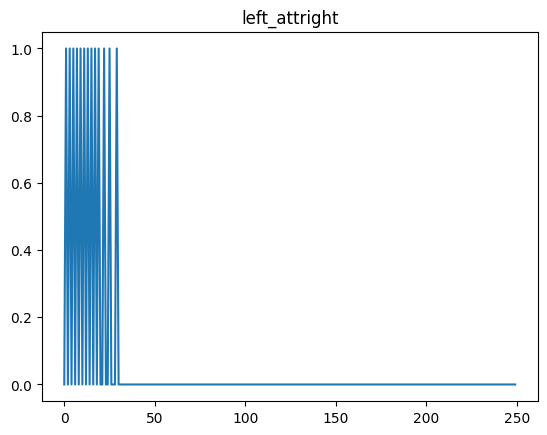

(479, 250, 160)


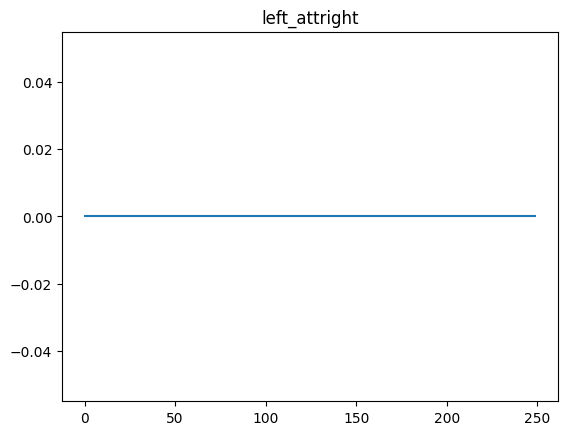

(501, 250, 160)


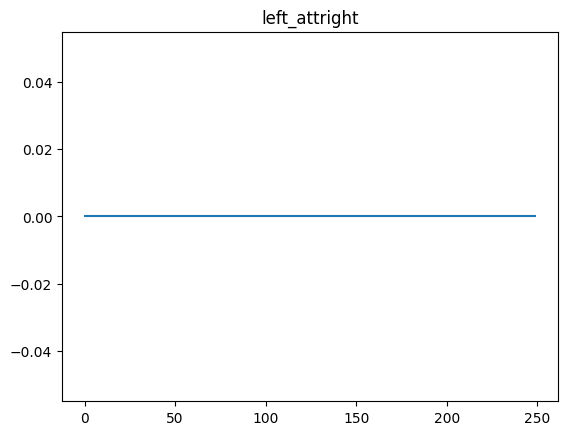

In [3]:
_, l_ar, _, r_ar, _, a_ar= collect_data(file_numbers)

In [4]:
def count_neuron_firings(data):
    return np.sum(data, axis=1)


In [5]:
#perhaps prep the data here - 
#will calculate mean and std for each neuron across trials 
#then will zscore per neuron
#perhaps rescale to 0-1 for each neuron across trials
#if i end up binning the data, perhaps zscore each bin
#should compute mean and std only using the training data, then zscore both training and test 
#using these training stats

def smooth_data(data, sigma=1):
    return gaussian_filter1d(data, sigma=sigma, axis=1)  #Gaussian filter along the time axis

def normalize_inputs(x_train, x_test, x_val):
    z_train = np.zeros_like(x_train)
    z_test = np.zeros_like(x_test)
    z_val = np.zeros_like(x_val)

    x_train = smooth_data(x_train, sigma=1)
    x_test = smooth_data(x_test, sigma=1)
    x_val = smooth_data(x_val, sigma=1)

    mean = np.mean(x_train, axis=0)  #(1, time, neurons)
    std = np.std(x_train, axis=0)

    #avoids divide-by-zero
    std[std < 1e-6] = 1.0

    z_train = (x_train - mean) / std
    z_test  = (x_test - mean) / std
    z_val   = (x_val - mean) / std

    if np.isnan(z_train).any():
        raise ValueError("Data contains NaN values after normalization.")

    return (
        torch.tensor(z_train, dtype=torch.float32),
        torch.tensor(z_test, dtype=torch.float32),
        torch.tensor(z_val, dtype=torch.float32)
    )


def normalize_targets(y_train, y_test, y_val):
    mean = np.mean(y_train, axis = 0)  #shape (1, 80)
    std = np.std(y_train, axis=0)

    std[std < 1e-6] = 1.0

    y_train_norm = (y_train - mean) / std
    y_test_norm  = (y_test - mean) / std
    y_val_norm   = (y_val - mean) / std

    return (
        torch.tensor(y_train_norm, dtype=torch.float32),
        torch.tensor(y_test_norm, dtype=torch.float32),
        torch.tensor(y_val_norm, dtype=torch.float32),
        mean, std
    )


def prep_data(x, y, batch_size = 16, shuffle = True):
    x_raw = np.concatenate(x, axis = 0)
    y_raw = np.concatenate(y, axis = 0)
    print(x_raw.shape)
    print(y_raw.shape)

    y = count_neuron_firings(y_raw)  #counts neuron firings for each trial
    print(y.shape)


    x_train, x_test, y_train, y_test = train_test_split(x_raw, y, test_size=0.2, random_state=42, shuffle=True)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

    x_train, x_test, x_validation = normalize_inputs(x_train, x_test, x_validation)
    y_train, y_test, y_validation, mean, std = normalize_targets(y_train, y_test, y_validation)

    plt.plot(y_train[0, :])
    plt.title('y_train')
    plt.show()

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True, num_workers=0)
    return train_loader, x_test, y_test, x_validation, y_validation, mean, std


(1398, 250, 160)
(1398, 250, 80)
(1398, 80)


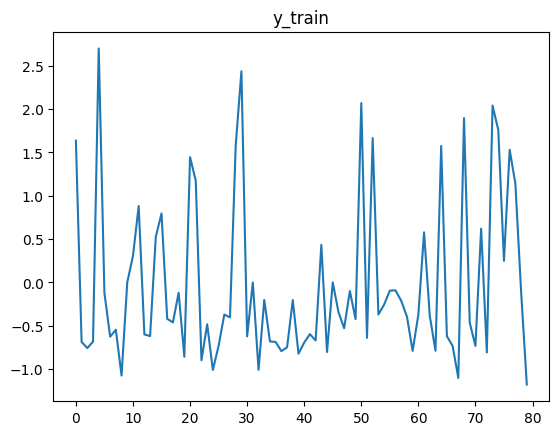

(<torch.utils.data.dataloader.DataLoader at 0x1f6908fc690>,
 tensor([[[ 0.4903,  0.2326,  0.0000,  ..., -0.5591,  0.4587,  1.2205],
          [ 1.2640,  2.3059,  0.0000,  ...,  0.1288,  1.2466,  0.9166],
          [ 1.4081,  4.0610, -0.0335,  ...,  0.3377,  1.3866,  0.4808],
          ...,
          [-0.0973, -0.0666,  0.0000,  ..., -0.3783, -0.0341, -0.3265],
          [-0.0998, -0.0691,  0.0000,  ..., -0.3481, -0.0335, -0.3297],
          [-0.0775, -0.0649,  0.0000,  ..., -0.2776, -0.0335, -0.2736]],
 
         [[-0.6527, -0.2525,  0.0000,  ...,  1.0685, -0.6957, -0.2926],
          [-0.7520, -0.3317,  0.0000,  ...,  0.6819, -0.8350,  0.4459],
          [-0.7678, -0.3497, -0.0335,  ...,  0.4966, -0.8530,  0.6436],
          ...,
          [-0.0973, -0.0666,  0.0000,  ..., -0.3783, -0.0341, -0.3265],
          [-0.0998, -0.0691,  0.0000,  ..., -0.3481, -0.0335, -0.3297],
          [-0.0775, -0.0649,  0.0000,  ..., -0.2776, -0.0335, -0.2736]],
 
         [[-0.4305, -0.2525,  0.0000,  .

In [6]:
prep_data(l_al, a_al, batch_size = 16, shuffle = True)

In [7]:
class SpikingAttentionLSTM(nn.Module):
    def __init__(self, input_dim = 160, hidden_dim = 128, output_dim = 80, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim, 
            batch_first = True,
            num_layers = num_layers,
            dropout = dropout if num_layers > 1 else 0.0,  #dropout only applies if num_layers > 1

        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)  #dropout layer

    def forward(self, x):
        output, _ = self.lstm(x)  #(batch, time, hidden)
        pooled = output.mean(dim=1)  #mean over time → shape: (batch, hidden)
        dropped = self.dropout(pooled)
        out = self.fc(dropped)  #shape: (batch, 80)
        return out
    
class SpikingAttentionNN(nn.Module):
    def __init__(self, input_dim = 160, output_dim = 80, hidden_dim = 128, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    

In [8]:
def train(model, train_loader, x_val, y_val, 
           criterion, epochs=1000, clip_value = 1.0, 
           lr = 0.001, patience = 20):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_history = []
    validation_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  #gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = criterion(y_val_pred, y_val)
            val_loss_item = val_loss.item()
            validation_loss_history.append(val_loss.item())

        #early stopping
        if val_loss_item < best_val_loss:
            best_val_loss = val_loss_item
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            print(f"Early stopping at epoch {epoch} with validation loss: {best_val_loss:.4f}")
            break

        if epoch % 10 == 0:
            clear_output(wait=True)  #clears the Jupyter output cell
            plt.figure(figsize=(10, 7))
            plt.plot(loss_history, label = 'Training Loss')
            plt.plot(validation_loss_history, label = 'Validation Loss')
            plt.legend()
            plt.xlim(0, epochs)
            plt.ylim(0, 0.7)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Losses')
            plt.grid(True)
            plt.show()


    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return loss_history, validation_loss_history


In [9]:
def plot_predictions_vs_ground_truth(model_left, x_data_left, y_data_left, model_right, x_data_right, y_data_right, num_examples=5, width = 16):
    """
    model     : your trained model
    x_data    : (n_trials, time, input_dim) or subset for val/test set
    y_data    : (n_trials, output_dim) ground truth
    num_examples : how many random trials to plot
    """
    model_left.eval()
    with torch.no_grad():
        y_pred_left = model_left(x_data_left)  #(n_trials, 80)
    
    y_pred_left_np = y_pred_left.detach().cpu().numpy()
    y_data_left_np = y_data_left.detach().cpu().numpy() if isinstance(y_data_left, torch.Tensor) else y_data_left

    n_trials = y_pred_left_np.shape[0]

    model_right.eval()
    with torch.no_grad():
        y_pred_right = model_right(x_data_right)

    y_pred_right_np = y_pred_right.detach().cpu().numpy()
    y_data_right_np = y_data_right.detach().cpu().numpy() if isinstance(y_data_right, torch.Tensor) else y_data_right
    
    #randomly choose some trials to visualize
    trials_to_plot = np.random.choice(n_trials, size=num_examples, replace=False)

    fig, ax = plt.subplots(2, num_examples, figsize=(width, 7))

    if num_examples == 1:
        ax = np.array(ax).reshape(2, 1)
        
    for i, trial_idx in enumerate(trials_to_plot):
        ax[0, i].plot(y_data_left_np[trial_idx], 'ko-', label='Ground Truth')
        ax[0, i].plot(y_pred_left_np[trial_idx], 'ro-', label='Prediction')
        ax[0, i].set_title(f'Left Model - Trial {trial_idx}')
        ax[0, i].set_xlabel('Neuron Index')
        ax[0, i].set_ylabel('Firing Rate')
        ax[0, i].legend()
        ax[0, i].grid(True)

        ax[1, i].plot(y_data_right_np[trial_idx], 'ko-', label='Ground Truth')
        ax[1, i].plot(y_pred_right_np[trial_idx], 'ro-', label='Prediction')
        ax[1, i].set_title(f'Right Model - Trial {trial_idx}')
        ax[1, i].set_xlabel('Neuron Index')
        ax[1, i].set_ylabel('Firing Rate')
        ax[1, i].legend()
        ax[1, i].grid(True)

    plt.tight_layout()
    plt.show()


  

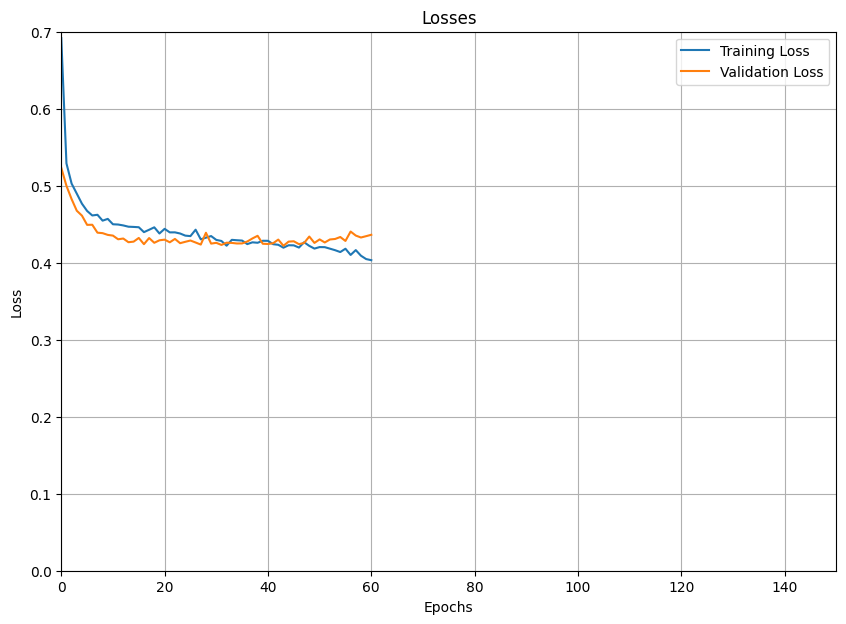

Early stopping at epoch 63 with validation loss: 0.4220
y_pred shape: (304, 80)


In [10]:
#training loop
train_loader_left, x_test_left, y_test_left, x_validation_left, y_validation_left, _, _ = prep_data(l_ar, a_ar, batch_size = 32, shuffle = True)

n_neurons_in = x_test_left.shape[2]
print('n_neurons:', n_neurons_in)

model_left = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 32, output_dim = 80, num_layers = 2, dropout = 0.3)

criterion =  nn.MSELoss()
loss_history_left, validation_loss_history_left = train(model_left, train_loader_left, x_validation_left, y_validation_left,
                 criterion, epochs = 150, lr = 0.005, patience = 20)

model_left.eval()
y_pred_trained_l = model_left(x_test_left).detach().numpy()
print('y_pred shape:', y_pred_trained_l.shape)

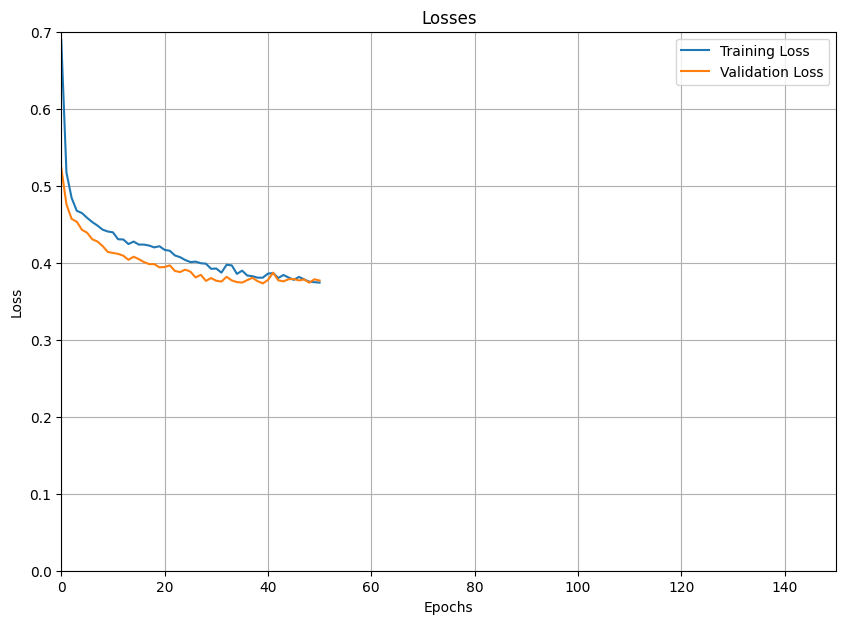

Early stopping at epoch 59 with validation loss: 0.3731
y_pred shape: (304, 80)


In [11]:
#training loop
train_loader_right, x_test_right, y_test_right, x_validation_right, y_validation_right, _, _ = prep_data(r_ar, a_ar, batch_size = 32, shuffle = True)

n_neurons_in = x_test_right.shape[2]
print('n_neurons:', n_neurons_in)

model_right = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 32, output_dim = 80, num_layers = 2, dropout = 0.3)

criterion =  nn.MSELoss()
loss_history_right, validation_loss_history_right = train(model_right, train_loader_right, x_validation_right, y_validation_right,
                 criterion, epochs = 150, lr = 0.005, patience = 20)

model_right.eval()
y_pred_trained_r = model_right(x_test_right).detach().numpy()
print('y_pred shape:', y_pred_trained_r.shape)

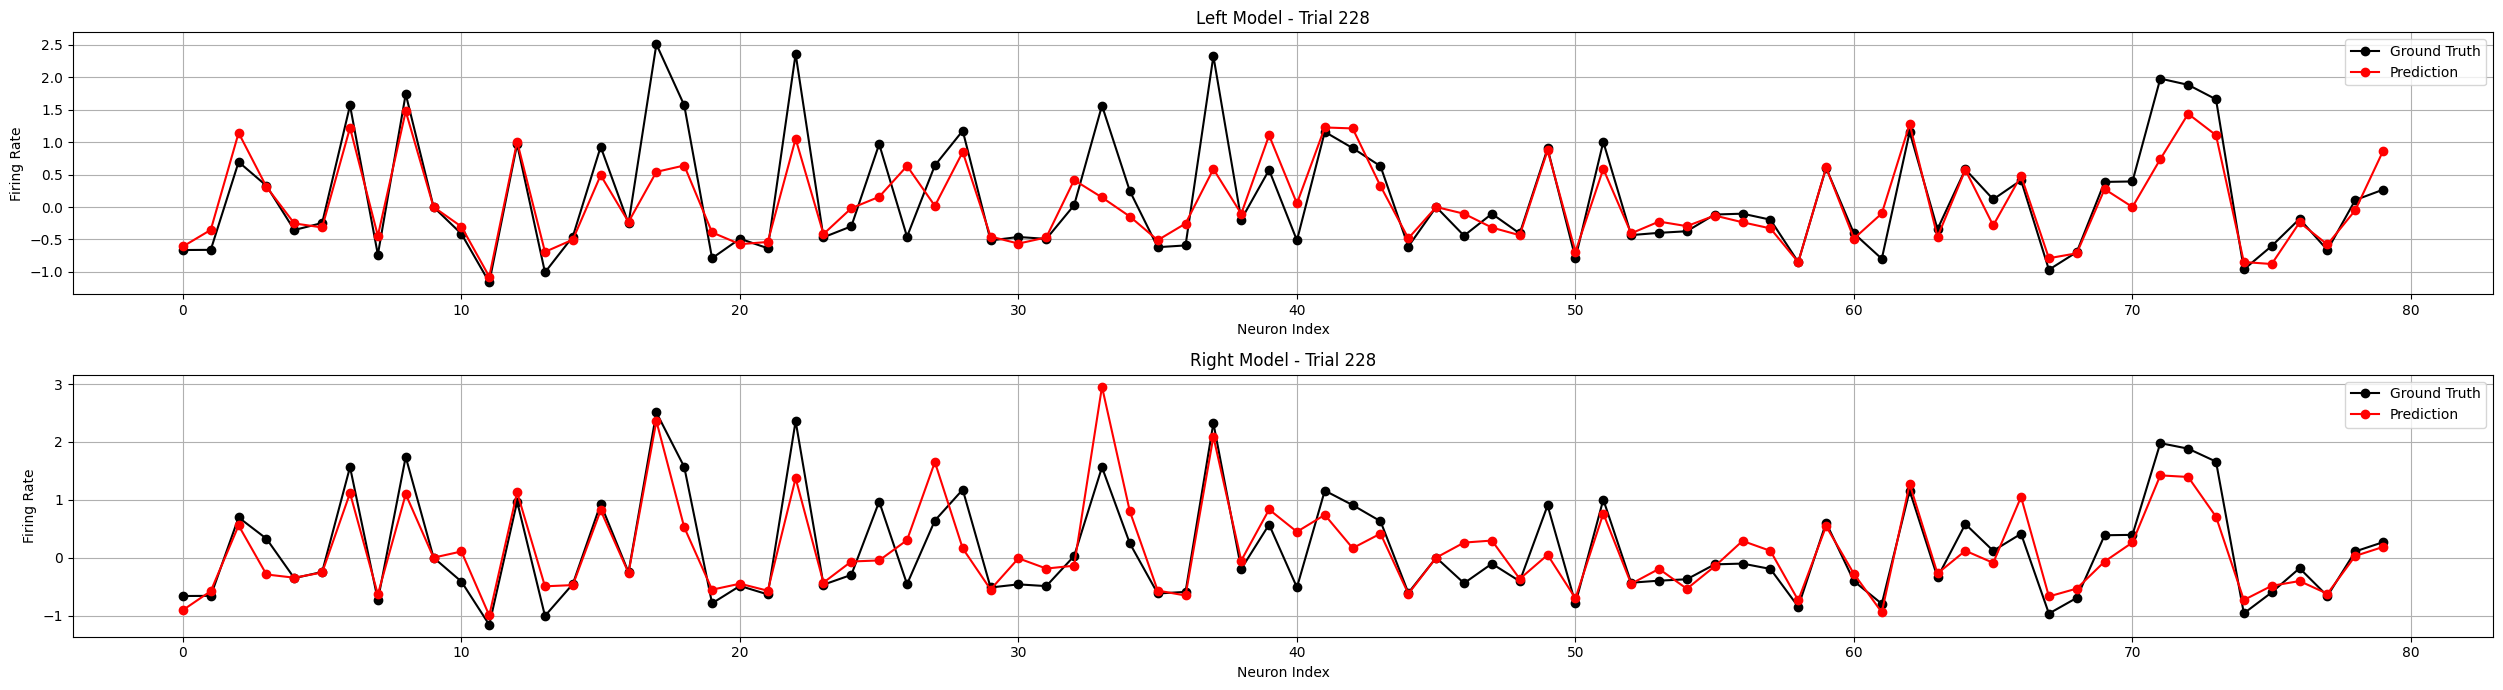

In [12]:
plot_predictions_vs_ground_truth(model_left, x_test_left, y_test_right, model_right, x_test_right, y_test_right, num_examples=1, width = 25)
#plot_predictions_vs_ground_truth(model_left, x_test_left, y_test_right, model_right, x_test_right, y_test_right, num_examples=3)



Overall Pearson Correlation: 0.7388907291471198
Overall Pearson Correlation: 0.7786761462066927


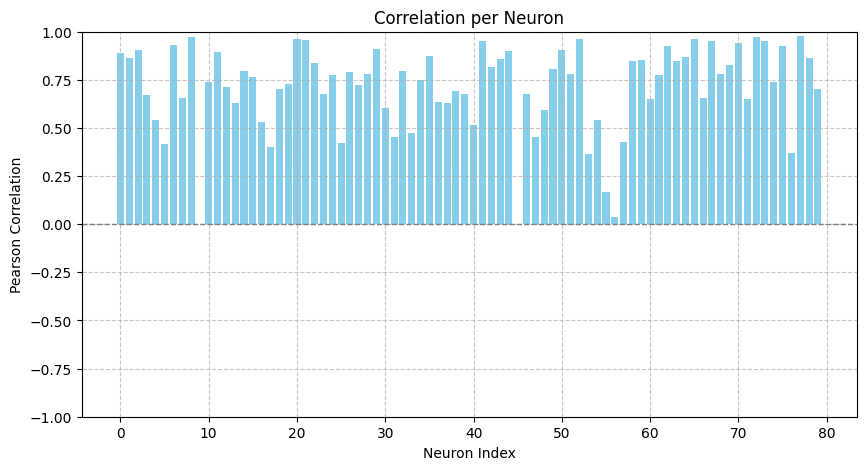

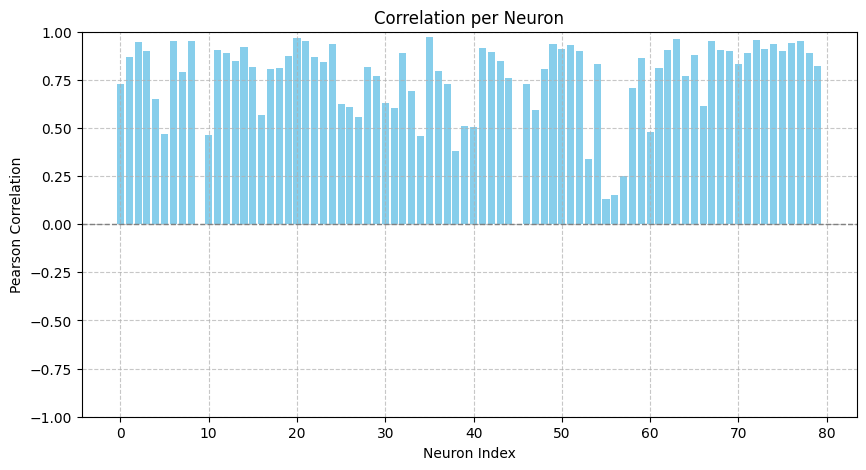

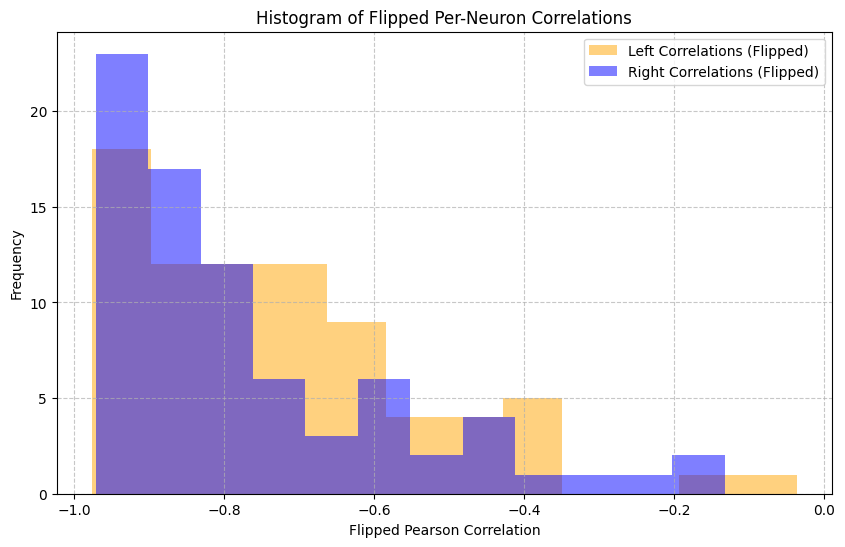

In [13]:
def compute_correlations(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.detach().cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.detach().cpu().numpy()

    flat_y_true = y_true.flatten()
    flat_y_pred = y_pred.flatten()
    overall_corr = np.corrcoef(flat_y_true, flat_y_pred)[0, 1]

    #per-neuron correlation along trials
    n_trials, n_neurons = y_true.shape
    per_neuron_corr = np.zeros(n_neurons)
    for i in range(n_neurons):
        # Option 1: Using np.corrcoef:
        per_neuron_corr[i] = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        # Option 2: Alternatively, you can use scipy.stats.pearsonr:
        # r, _ = pearsonr(y_true[:, i], y_pred[:, i])
        # per_neuron_corr[i] = r

    return overall_corr, per_neuron_corr


overall_corr_left, per_neuron_corr_left = compute_correlations(y_test_left, y_pred_trained_l)
overall_corr_right, per_neuron_corr_right = compute_correlations(y_test_right, y_pred_trained_r)

print("Overall Pearson Correlation:", overall_corr_left)
#print("Per-neuron Pearson Correlations:", per_neuron_corr_left)
print("Overall Pearson Correlation:", overall_corr_right)
#print("Per-neuron Pearson Correlations:", per_neuron_corr_right)


# Optional: A function to visualize per-neuron correlations
def plot_neuron_correlations(per_neuron_corr):

    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(len(per_neuron_corr)), per_neuron_corr, color='skyblue')
    plt.xlabel('Neuron Index')
    plt.ylabel('Pearson Correlation')
    plt.title('Correlation per Neuron')
    plt.ylim([-1, 1])
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# To visualize the per-neuron correlations:
plot_neuron_correlations(per_neuron_corr_left)
plot_neuron_correlations(per_neuron_corr_right)

plt.figure(figsize=(10, 6))
plt.hist(-per_neuron_corr_left, bins=12, alpha=0.5, label='Left Correlations (Flipped)', color='orange')
plt.hist(-per_neuron_corr_right, bins=12, alpha=0.5, label='Right Correlations (Flipped)', color='blue')
plt.xlabel('Flipped Pearson Correlation')
plt.ylabel('Frequency')
plt.title('Histogram of Flipped Per-Neuron Correlations')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
